<img src="https://imagedelivery.net/Dr98IMl5gQ9tPkFM5JRcng/3e5f6fbd-9bc6-4aa1-368e-e8bb1d6ca100/Ultra" alt="Image description" width="160" />

<br/>

# Forget RAG Pipelines — Build Production-Ready AI Agents in 15 Minutes
### Updated from a Workshop session at AI Engineer's World Fair
#### 7.23 11:00 am PT

Want to take advantage of your data, but don't want to reinvent RAG infrastructure? Join our workshop and see how you can deploy Agentic RAG in minutes using Contextual AI's managed RAG solution. We'll explore how Contextual handles intelligent parsing and chunking of your data, retrieves information with state-of-the-art accuracy, and generates responses with a multi layered set of guardrails against hallucinations. Together, we'll build an end-to-end Agentic RAG pipeline and share additional resources on how you can integrate it remotely via MCP, so you can see how this could plug into your existing ecosystem.

By the end of this session, you'll have a functioning Agentic RAG prototype that you can easily customize and deploy to production for your specific use cases, even with complex, unstructured documents.

**Contextual AI** lets you create and use generative AI agents. This notebook introduces an end-to-end example workflow for creating a **Retrieval-Augmented Generation (RAG)** agent for a financial use case. The agent will answer questions based on the documents provided, answering questions across several documents, but will **NOT** add its own perspective on the documents. This notebook uses the Python client.

This notebook covers the following steps:

- **Creating a Datastore**  
- **Ingesting Documents**  
- **Creating an RAG Agent**  
- **Querying an RAG Agent**  
- **Evaluating an RAG Agent**  
- **Improving the RAG Agent (Updating prompt)**  

The notebook can be run in **under 15 minutes**. The full documentation is available at [docs.contextual.ai](https://docs.contextual.ai/)


### Start by making a copy of this notebook

In [ ]:
%pip install contextual-client matplotlib tqdm requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.8/175.8 kB 5.9 MB/s eta 0:00:00


In [ ]:
import os
import json
import requests
from pathlib import Path
from typing import List, Optional, Dict
from IPython.display import display, JSON
import pandas as pd
from contextual import ContextualAI
import ast

## Step 0: Get your API credentials and save them in the notebook
**Note**: If you do not have access to the platform, you can create a workspace via the [Start Free](https://app.contextual.ai/?signup=1) button in the upper right of the page. New workspaces are given a 30-day free trial of an agent and datastore. Note that each workspace needs a unique name.

We are saving the key in Google Colab secrets, but feel free to use your preferred API key management process.

Contextual uses API keys to authenticate requests. Only admins within a workspace can create API keys. To create a key:
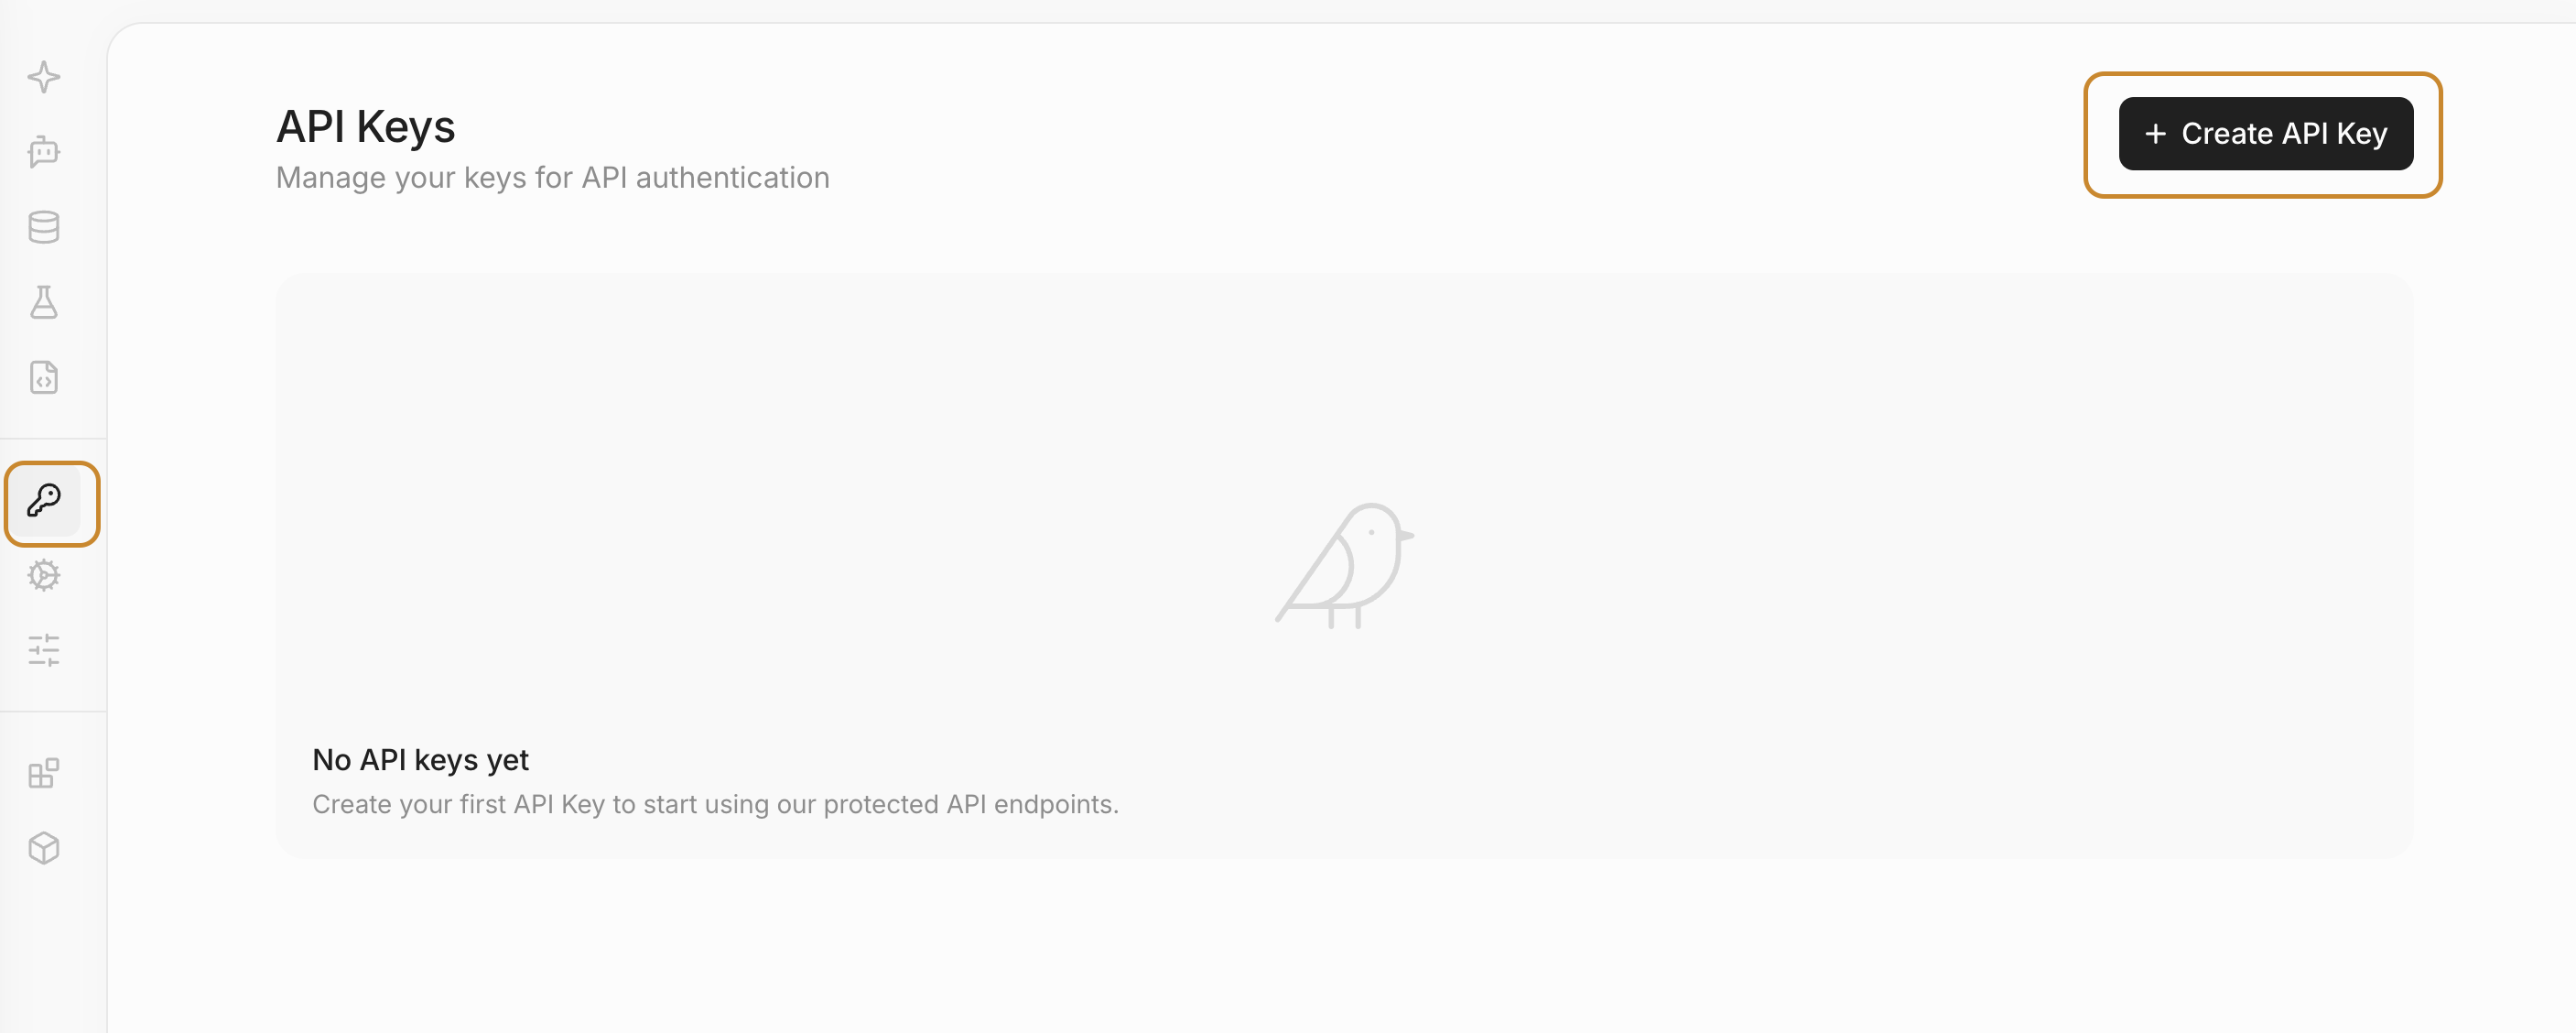



1. Log into your tenant at [app.contextual.ai](app.contextual.ai)
2. Click on **API Keys** in the sidebar
3. Click the **Create API Key** button in the upper right and follow the instructions
4. Add new secret key  "CONTEXTUAL_API_KEY" in your Colab notebook
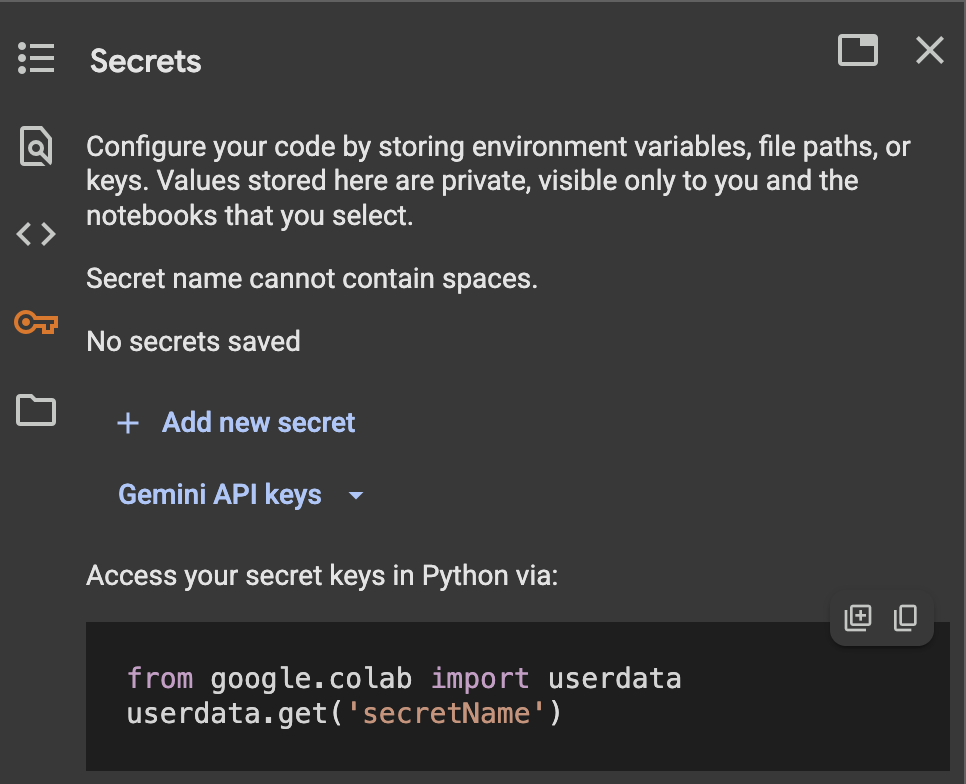
5. Please keep your key in a secure place, and do not share it with anyone


In [ ]:
#Setup API key
from google.colab import userdata

client = ContextualAI(
    api_key=userdata.get('CONTEXTUAL_API_KEY'),  # This is the default and can be omitted
)

## Step 1: Create your Datastore

You will first need to create a datastore for your agent using the `/datastores` endpoint.

A datastore provides secure storage for data. Each agent has its own datastore to keep data stored securely and isolated.

In [ ]:
datastore_name = 'AIE_demo_RAG'

# Check if datastore exists
datastores = client.datastores.list()
existing_datastore = next((ds for ds in datastores if ds.name == datastore_name), None)

if existing_datastore:
    datastore_id = existing_datastore.id
    print(f"Using existing datastore with ID: {datastore_id}")
else:
    result = client.datastores.create(name=datastore_name)
    datastore_id = result.id
    print(f"Created new datastore with ID: {datastore_id}")

Created new datastore with ID: b884672e-a2d3-4721-a9d7-ad24f799aa2f


## Step 2: Ingest Documents into Your Datastore

You now can ingest documents into your Agent's datastore via the `/datastores` endpoint. For best results, use renderable PDFs—documents containing selectable, copyable text. Supported file formats include: PDF, HTML, DOC(X), and PPT(X). (For details, see the [reference](https://docs.contextual.ai/api-reference/datastores-documents/ingest-document))

In this example, we use several sample PDFs, but you’re free to upload your own documents. Note: Processing very long documents (hundreds of pages) may require additional time.


In [ ]:
import os
import requests

# Create data directory if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

# File list with corresponding GitHub URLs
files_to_upload = [
    ("A_Rev_by_Mkt_Qtrly_Trend_Q425.pdf", "https://raw.githubusercontent.com/ContextualAI/examples/refs/heads/main/08-ai-workshop/data/A_Rev_by_Mkt_Qtrly_Trend_Q425.pdf"),
    ("B_Q423-Qtrly-Revenue-by-Market-slide.pdf", "https://raw.githubusercontent.com/ContextualAI/examples/refs/heads/main/08-ai-workshop/data/B_Q423-Qtrly-Revenue-by-Market-slide.pdf"),
    ("C_Neptune.pdf", "https://raw.githubusercontent.com/ContextualAI/examples/refs/heads/main/08-ai-workshop/data/C_Neptune.pdf"),
    ("D_Unilever.pdf", "https://raw.githubusercontent.com/ContextualAI/examples/refs/heads/main/08-ai-workshop/data/D_Unilever.pdf")
]

Let's download and ingest the files

In [ ]:
# Download and ingest all files
document_ids = []
for filename, url in files_to_upload:
    file_path = f'data/{filename}'

    # Download file if it doesn't exist
    if not os.path.exists(file_path):
        print(f"Fetching {file_path}")
        try:
            response = requests.get(url)
            response.raise_for_status()  # Raise an exception for bad status codes
            with open(file_path, 'wb') as f:
                f.write(response.content)
        except Exception as e:
            print(f"Error downloading {filename}: {str(e)}")
            continue

    # Upload to datastore
    try:
        with open(file_path, 'rb') as f:
            ingestion_result = client.datastores.documents.ingest(datastore_id, file=f)
            document_id = ingestion_result.id
            document_ids.append(document_id)
            print(f"Successfully uploaded {filename} to datastore {datastore_id}")
    except Exception as e:
        print(f"Error uploading {filename}: {str(e)}")

print(f"Successfully uploaded {len(document_ids)} files to datastore")
print(f"Document IDs: {document_ids}")

Fetching data/A_Rev_by_Mkt_Qtrly_Trend_Q425.pdf
Successfully uploaded A_Rev_by_Mkt_Qtrly_Trend_Q425.pdf to datastore b884672e-a2d3-4721-a9d7-ad24f799aa2f
Fetching data/B_Q423-Qtrly-Revenue-by-Market-slide.pdf
Successfully uploaded B_Q423-Qtrly-Revenue-by-Market-slide.pdf to datastore b884672e-a2d3-4721-a9d7-ad24f799aa2f
Fetching data/C_Neptune.pdf
Successfully uploaded C_Neptune.pdf to datastore b884672e-a2d3-4721-a9d7-ad24f799aa2f
Fetching data/D_Unilever.pdf
Successfully uploaded D_Unilever.pdf to datastore b884672e-a2d3-4721-a9d7-ad24f799aa2f
Successfully uploaded 4 files to datastore
Document IDs: ['53d78e95-010c-463e-96f3-83b71123e539', '116363c8-097c-46e7-aab9-b8bfc44fa736', '0bb6bf9f-69ae-4b9b-a4df-d4ce0b63a55d', '71f343e2-00c2-4ea1-97bd-175ffdcc5edd']


### Let's take a look at our documents at [https://app.contextual.ai/](https://app.contextual.ai/)

1. Navigate to your workspace  
2. Select **Datastores** on the left menu  
3. Select **Documents**  
4. Click on **Inspect** (once documents load)  

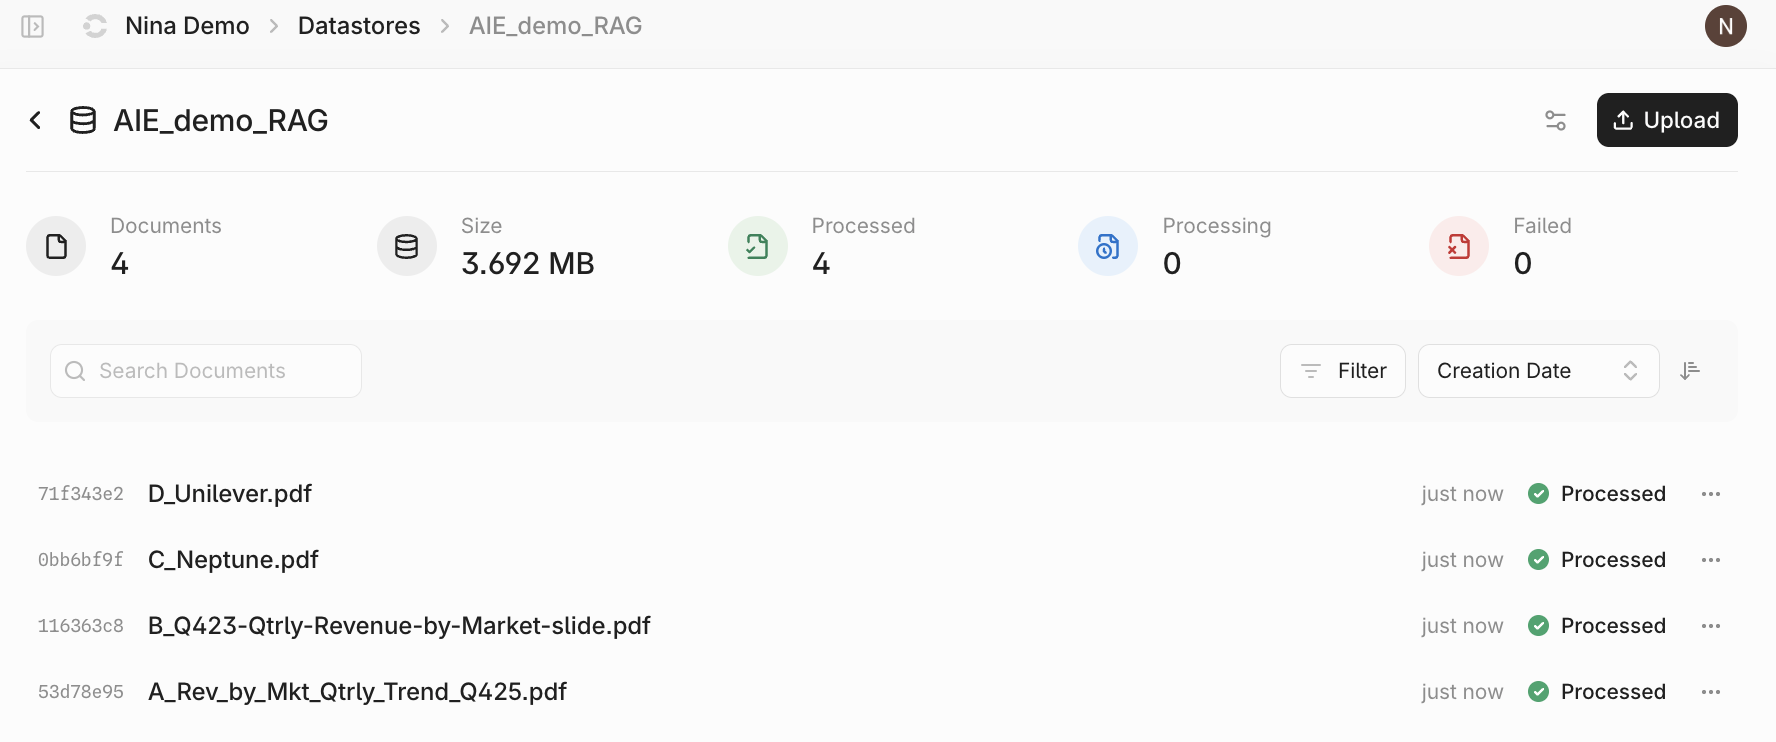

### Let's expand on Contextual's SoTA RAG Platform while documents ingest
[Workshop slide deck](https://contextual.ai/workshop)


Once ingested, you can view the list of documents, see their metadata, and also delete documents via API.

**Note:** It may take a few minutes for the document to be ingested and processed. If the documents are still being ingested, you will see `status='processing'`. Once ingestion is complete, the status will show as `status='completed'`.

You can learn more about the metadata [here](https://docs.contextual.ai/api-reference/datastores-documents/get-document-metadata).

In [ ]:
metadata = client.datastores.documents.metadata(datastore_id = datastore_id, document_id = document_ids[0])
print("Document metadata:", metadata)

Document metadata: DocumentMetadata(id='53d78e95-010c-463e-96f3-83b71123e539', created_at='2025-07-22T23:55:12.400703', name='A_Rev_by_Mkt_Qtrly_Trend_Q425.pdf', status='completed', custom_metadata={}, updated_at=None, custom_metadata_config={})


## Step 3: Create your Agent

Next, let's create the Agent and modify it to suit our needs.

You can customize the Agent using additional parameters such as:

- **`system_prompt`** is used for the instructions that your RAG system references when generating responses. Note that we do not guarantee that the system will follow these instructions exactly.

- **`llm_model_id`** *(optional)* specifies the model ID of a tuned model to use for generation. Contextual AI will use a default model if none is specified.

You can find all the additional parameters [here](https://docs.contextual.ai/api-reference/agents/create-agent)

In [ ]:
system_prompt = '''
You are a helpful AI assistant created by Contextual AI to answer questions about relevant documentation provided to you. Your responses should be precise, accurate, and sourced exclusively from the provided information. Please follow these guidelines:
* Only use information from the provided documentation. Avoid opinions, speculation, or assumptions.
* Use the exact terminology and descriptions found in the provided content.
* Keep answers concise and relevant to the user's question.
* Use acronyms and abbreviations exactly as they appear in the documentation or query.
* Apply markdown if your response includes lists, tables, or code.
* Directly answer the question, then STOP. Avoid additional explanations unless specifically relevant.
* If the information is irrelevant, simply respond that you don't have relevant documentation and do not provide additional comments or suggestions. Ignore anything that cannot be used to directly answer this query.
  '''


In [ ]:
agent_name = "Demo-AIE"
# Get list of existing agents
agents = client.agents.list()

# Check if agent already exists
existing_agent = next((agent for agent in agents if agent.name == agent_name), None)

if existing_agent:
    agent_id = existing_agent.id
    print(f"Using existing agent with ID: {agent_id}")
else:
    print("Creating new agent")
    app_response = client.agents.create(
        name=agent_name,
        description="Helpful Grounded AI Assistant",
        datastore_ids=[datastore_id],
        agent_configs={
        "global_config": {
            "enable_multi_turn": False # Turning this off for deterministic responses
        }
        },
        suggested_queries=[
            "What was NVIDIA's annual revenue by fiscal year 2022 to 2025?",
            "When did NVIDIA's data center revenue overtake gaming revenue?",
            "What's the correlation between the distance between Neptune and the Sun and Burglary rates in the US?",
            "What's the correlation between Global revenue generated by Unilever Group and Google searches for 'lost my wallet'?",
            "Does this imply that Unilever Group's revenue is derived from lost wallets?",
            "What's the correlation between the distance between Neptune and the Sun and Global revenue generated by Unilever Group?"
        ]
    )
    agent_id = app_response.id
    print(f"Agent ID created: {agent_id}")

Creating new agent
Agent ID created: be8fdc75-6645-42c6-b497-13e88a9246d5


### Let's look at our Agent in the Platform

Visit: [https://app.contextual.ai/](https://app.contextual.ai/)

1. Navigate to your workspace  
2. Select **Agents** from the left menu  
3. Select your Agent  
4. Type your question  


## Step 4: Query Your Agent via API

Now let's query our Agent using the API. The required fields are:

- **`agent_id`**: The unique identifier of your Agent  
- **`messages`**: A list of message(s) forming the user query  

Optional information includes parameters for `stream` and `conversation_id`. You can refer [here](https://docs.contextual.ai/api-reference/agents-query/query) for more information.

Let's try this query:  **"What was NVIDIA's annual revenue by fiscal year 2022 to 2025?"**

In [ ]:
query_result = client.agents.query.create(
    agent_id=agent_id,
    messages=[{
        "content": "What was NVIDIA's annual revenue by fiscal year 2022 to 2025?",
        "role": "user"
    }]
)
print(query_result.message.content)

NVIDIA's annual revenue by fiscal year:

FY2022: $27,653 million ($7,643Q4 + $7,103Q3 + $6,507Q2 + $5,661Q1)[2]()

FY2023: $26,974 million ($6,051Q4 + $5,931Q3 + $6,704Q2 + $8,288Q1)[2]()

FY2024: $68,022 million ($22,103Q4 + $18,120Q3 + $13,507Q2 + $7,192Q1)[1]()

FY2025: $130,497 million ($39,331Q4 + $35,082Q3 + $30,040Q2 + $26,044Q1)[1]()

These figures are calculated by summing the quarterly revenues for each fiscal year from the provided data.


There is lots more information you can access from the query result. You can display the retrieved documents, for example.   


--- Processing Document 1 ---
Retrieval Info for Document 1: RetrievalInfoResponse(content_metadatas=[ContentMetadataUnstructuredContentMetadata(content_id='46c89aa2-01ca-34f0-c48f-d0b982bc573b', content_text='Filename: NVIDIA Quarterly Revenue Trend Q4 2025\n\n| ($ in millions) | Q4 FY25 | Q3 FY25 | Q2 FY25 | Q1 FY25 | Q4 FY24 | Q3 FY24 | Q2 FY24 | Q1 FY24 |\n|----------------------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|\n| Data Center | $35,580 | $30,771 | $26,272 | $22,563 | $18,404 | $14,514 | $10,323 | $4,284 |\n| Gaming | 2,544 | 3,279 | 2,880 | 2,647 | 2,865 | 2,856 | 2,486 | 2,240 |\n| Professional Visualization | 511 | 486 | 454 | 427 | 463 | 416 | 379 | 295 |\n| Auto | 570 | 449 | 346 | 329 | 281 | 261 | 253 | 296 |\n| OEM & Other | 126 | 97 | 88 | 78 | 90 | 73 | 66 | 77 |\n| TOTAL | $39,331 | $35,082 | $30,040 | $26,044 | $22,103 | $18,120 | $13,507 | $7,192 |\n\nNVIDIA QUARTERLY REVENUE TREND REVENUE BY MARKET

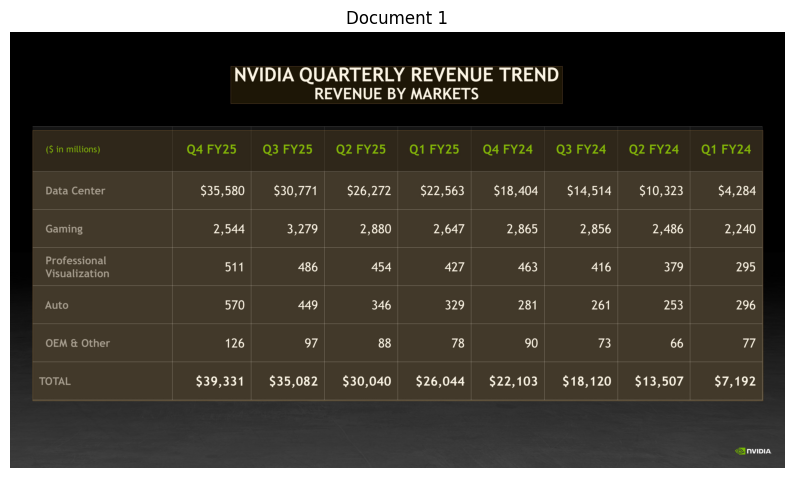


--- Processing Document 2 ---
Retrieval Info for Document 2: RetrievalInfoResponse(content_metadatas=[ContentMetadataUnstructuredContentMetadata(content_id='af045192-28bc-d824-6a77-1e6cab2d9cd8', content_text='Filename: NVIDIA Quarterly Revenue Trend by Market Q4 FY23\n\n| ($ in millions) | Q4 FY23 | Q3 FY23 | Q2 FY23 | Q1 FY23 | Q4 FY22 | Q3 FY22 | Q2 FY22 | Q1 FY22 |\n|----------------------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|\n| Data Center | $3,616 | $3,833 | $3,806 | $3,750 | $3,263 | $2,936 | $2,366 | $2,048 |\n| Gaming | 1,831 | 1,574 | 2,042 | 3,620 | 3,420 | 3,221 | 3,061 | 2,760 |\n| Professional Visualization | 226 | 200 | 496 | 622 | 643 | 577 | 519 | 372 |\n| Auto | 294 | 251 | 220 | 138 | 125 | 135 | 152 | 154 |\n| OEM & Other | 84 | 73 | 140 | 158 | 192 | 234 | 409 | 327 |\n| TOTAL | $6,051 | $5,931 | $6,704 | $8,288 | $7,643 | $7,103 | $6,507 | $5,661 |\n\nNVIDIA QUARTERLY REVENUE TREND REVENUE BY MARKE

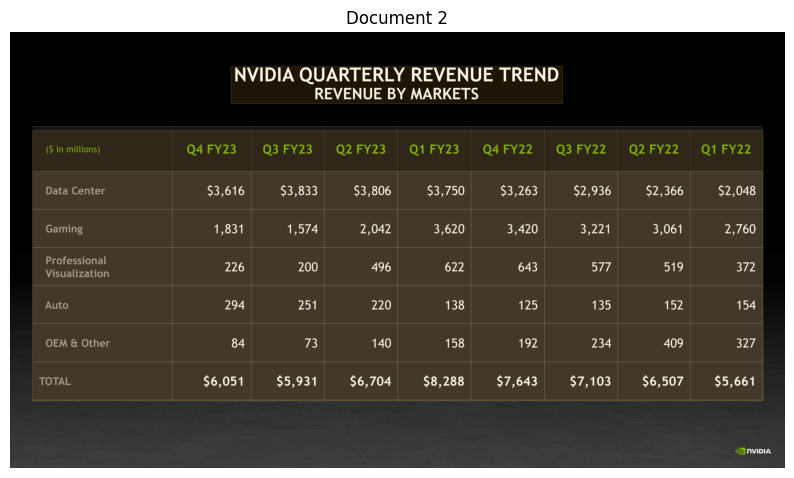


Total documents processed: 2


In [ ]:
import base64
import io
from PIL import Image
import matplotlib.pyplot as plt

def display_base64_image(base64_string, title="Document"):
    # Decode base64 string
    img_data = base64.b64decode(base64_string)

    # Create PIL Image object
    img = Image.open(io.BytesIO(img_data))

    # Display using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

    return img

# Retrieve and display all referenced documents
for i, retrieval_content in enumerate(query_result.retrieval_contents):
    print(f"\n--- Processing Document {i+1} ---")

    # Get retrieval info for this document
    ret_result = client.agents.query.retrieval_info(
        message_id=query_result.message_id,
        agent_id=agent_id,
        content_ids=[retrieval_content.content_id]
    )

    print(f"Retrieval Info for Document {i+1}:", ret_result)

    # Display the document image
    if ret_result.content_metadatas and ret_result.content_metadatas[0].page_img:
        base64_string = ret_result.content_metadatas[0].page_img
        img = display_base64_image(base64_string, f"Document {i+1}")
    else:
        print(f"No image available for Document {i+1}")

print(f"\nTotal documents processed: {len(query_result.retrieval_contents)}")

#### Questions we'll try via UI:

- When did NVIDIA’s data center revenue overtake gaming revenue?  
- What's the correlation between the distance between Neptune and the Sun and Burglary rates in the US?  
- What's the correlation between Global revenue generated by Unilever Group and Google searches for ‘lost my wallet’?  
- Does this imply that Unilever Group's revenue is derived from lost wallets?  
- What's the correlation between the distance between Neptune and the Sun and Global revenue generated by Unilever Group?  

#### Contrast the above with: https://chatgpt.com/


# Component code


## 1. [Parse](https://colab.research.google.com/github/ContextualAI/examples/blob/main/03-standalone-api/04-parse/parse.ipynb)

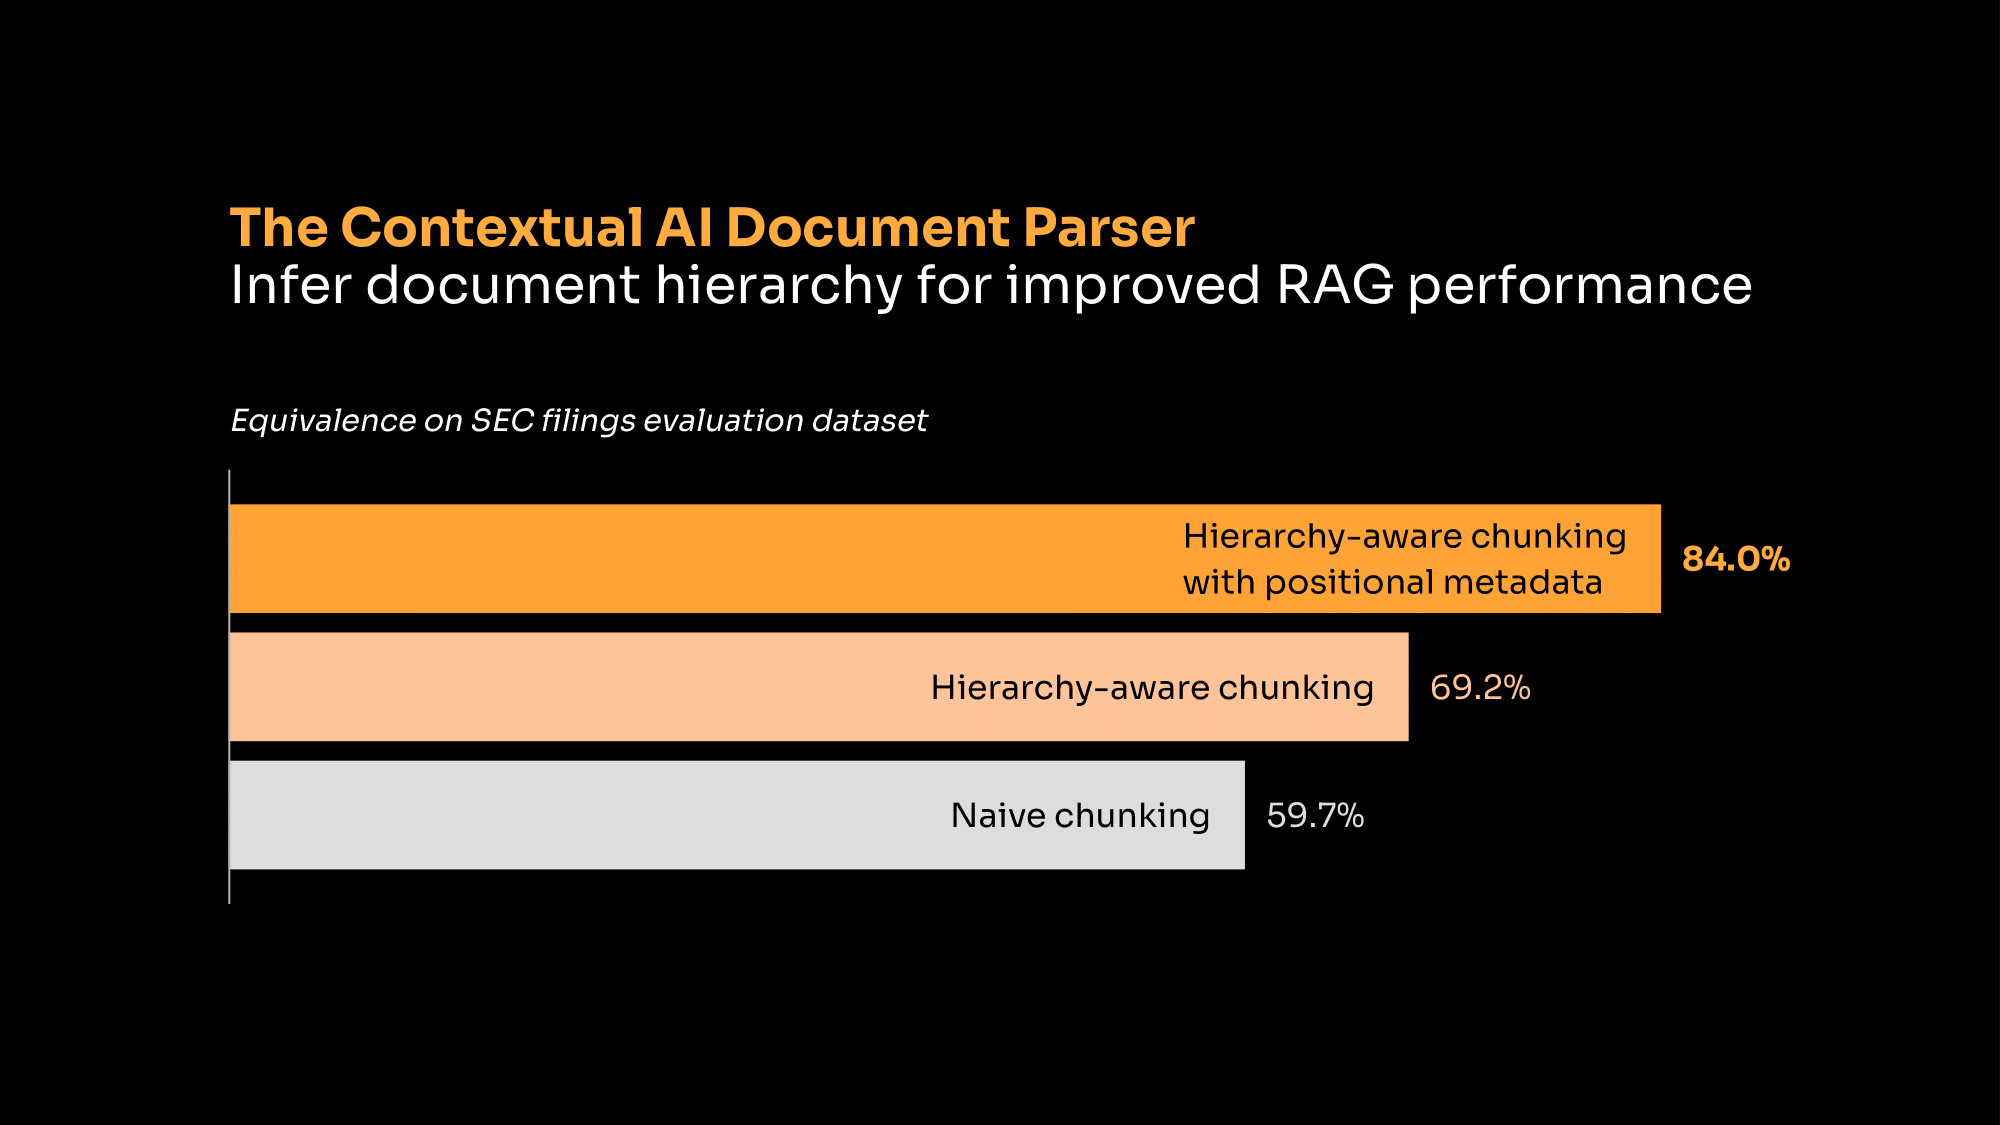

In [ ]:
# Example code:
url = "https://arxiv.org/pdf/1706.03762"

In [ ]:
import requests

# Download doc
file_path = "attention-is-all-you-need.pdf"
with open(file_path, "wb") as f:
    f.write(requests.get(url).content)

In [ ]:
import requests
import json

base_url = "https://api.contextual.ai/v1"

headers = {
    "accept": "application/json",
    "authorization": f"Bearer {userdata.get('CONTEXTUAL_API_KEY')}"
}

In [ ]:
url = f"{base_url}/parse"

config = {
    "parse_mode": "standard",
    "figure_caption_mode": "concise",
    "enable_document_hierarchy": True,
    "page_range": "0-5",
}

with open(file_path, "rb") as fp:
    file = {"raw_file": fp}
    result = requests.post(url, headers=headers, data=config, files=file)
    response = json.loads(result.text)

job_id = response['job_id']
job_id

'eb09d478-6bbe-4109-aef7-5b11135b7dd0'

In [ ]:
url = f"{base_url}/parse/jobs/{job_id}/results"

output_types = ["markdown-per-page"]

result = requests.get(
    url,
    headers=headers,
    params={"output_types": ",".join(output_types)},
)

result = json.loads(result.text)

In [ ]:
from IPython.display import display, Markdown

display(Markdown(result['pages'][0]['markdown']))

Provided proper attribution is provided, Google hereby grants permission to reproduce the tables and figures in this paper solely for use in journalistic or scholarly works.

# Attention Is All You Need

Noam Shazeer \*
Google Brain
noam@google.com

Ashish Vaswani \*
Google Brain
avaswani@google.com

Niki Parmar \*
Google Research
nikip@google.com

Jakob Uszkoreit \*
Google Research
usz@google.com

Aidan N. Gomez \*†
University of Toronto
aidan@cs.toronto.edu

Łukasz Kaiser \*
Google Brain
lukaszkaiser@google.com

Llion Jones \*
Google Research
llion@google.com

Illia Polosukhin \*‡
illia.polosukhin@gmail.com

## Abstract

The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles, by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature. We show that the Transformer generalizes well to other tasks by applying it successfully to English constituency parsing both with large and limited training data.

\* Equal contribution. Listing order is random. Jakob proposed replacing RNNs with self-attention and started the effort to evaluate this idea. Ashish, with Illia, designed and implemented the first Transformer models and has been crucially involved in every aspect of this work. Noam proposed scaled dot-product attention, multi-head attention and the parameter-free position representation and became the other person involved in nearly every detail. Niki designed, implemented, tuned and evaluated countless model variants in our original codebase and tensor2tensor. Llion also experimented with novel model variants, was responsible for our initial codebase, and efficient inference and visualizations. Łukasz and Aidan spent countless long days designing various parts of and implementing tensor2tensor, replacing our earlier codebase, greatly improving results and massively accelerating our research.

† Work performed while at Google Brain.

‡ Work performed while at Google Research.

## 2. [Rerank](https://colab.research.google.com/github/ContextualAI/examples/blob/main/03-standalone-api/03-rerank/rerank.ipynb)

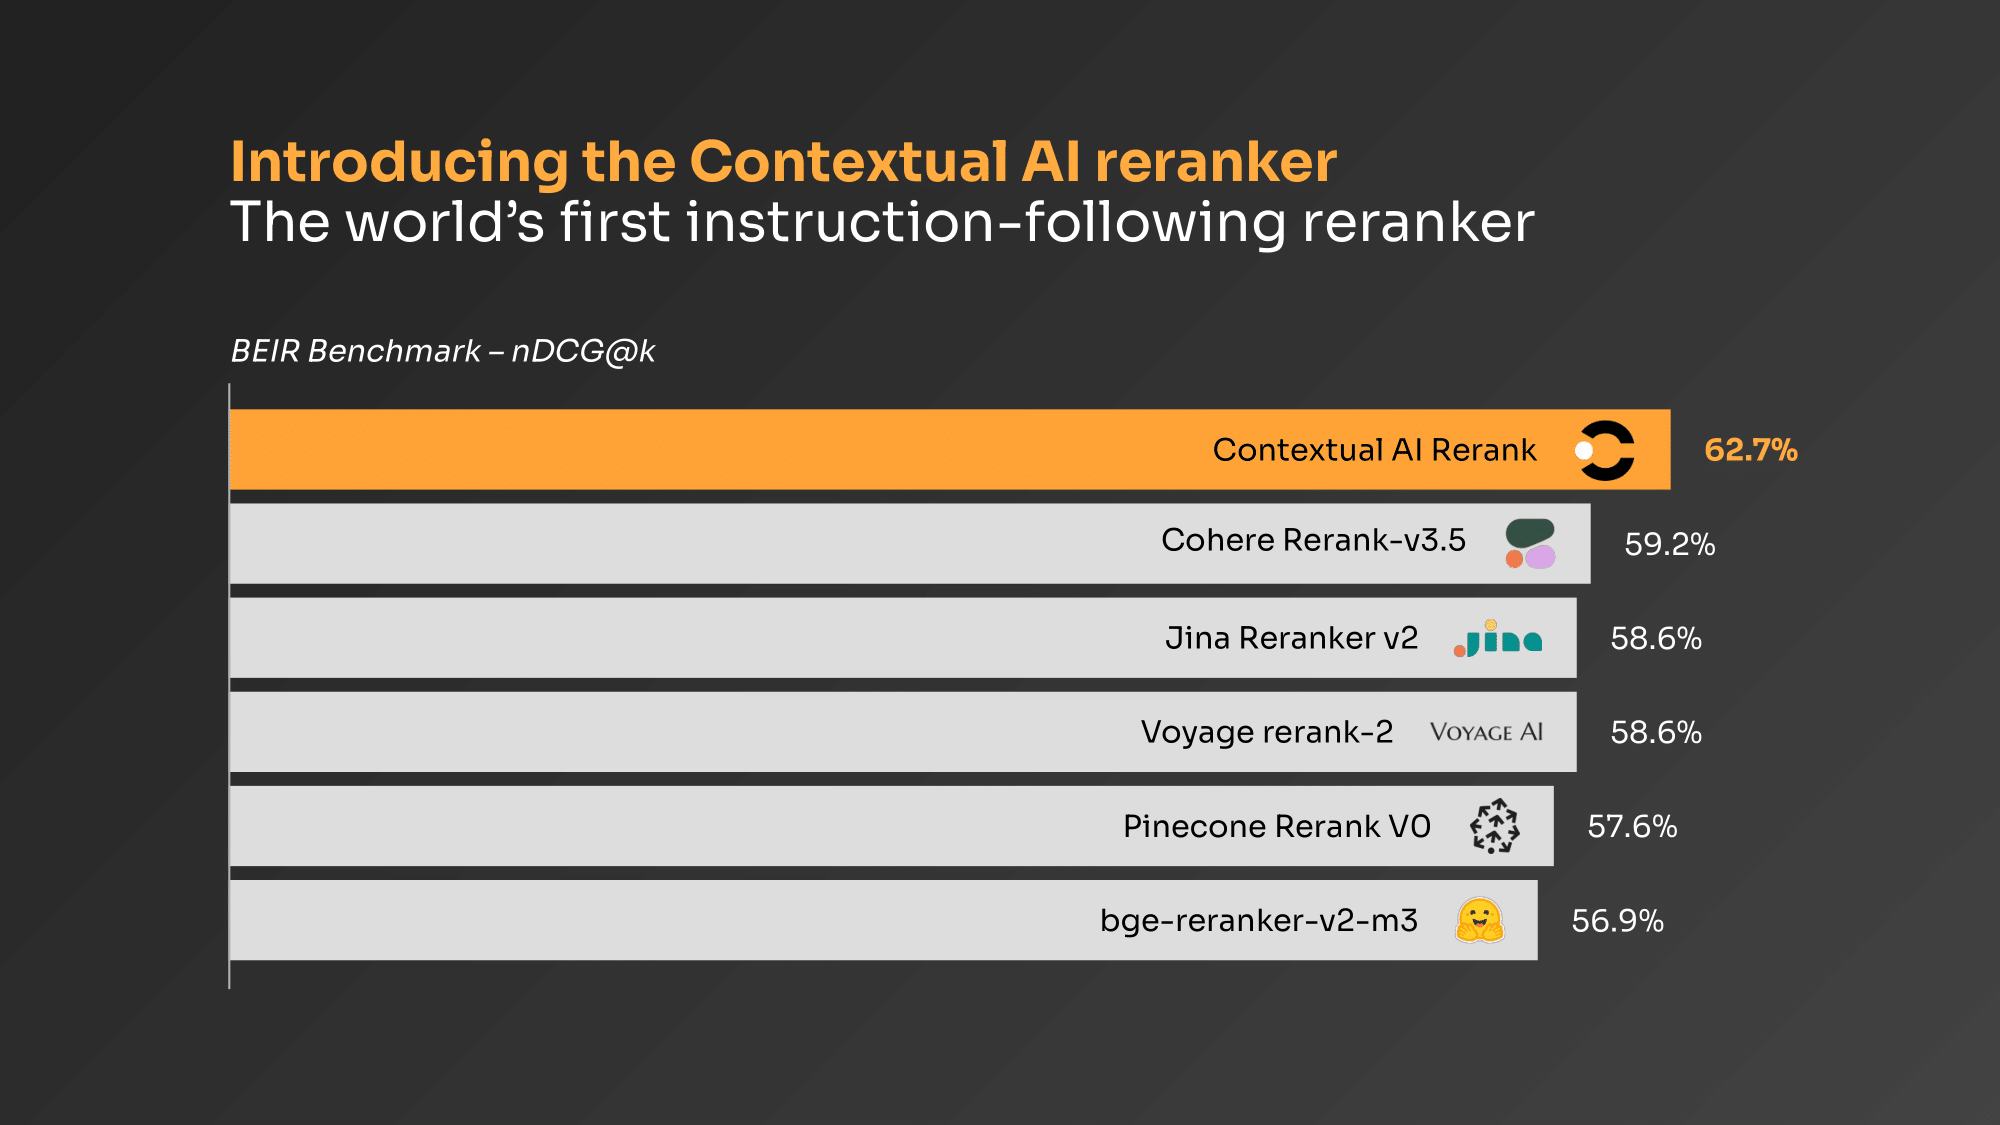

In [ ]:
# Example code:
rerank_api_endpoint = f"{base_url}/rerank"
query = "What is the current enterprise pricing for the RTX 5090 GPU for bulk orders?"

instruction = "Prioritize internal sales documents over market analysis reports. More recent documents should be weighted higher. Enterprise portal content supersedes distributor communications."

documents = [
    "Following detailed cost analysis and market research, we have implemented the following changes: AI training clusters will see a 15% uplift in raw compute performance, enterprise support packages are being restructured, and bulk procurement programs (100+ units) for the RTX 5090 Enterprise series will operate on a $2,899 baseline.",
    "Enterprise pricing for the RTX 5090 GPU bulk orders (100+ units) is currently set at $3,100-$3,300 per unit. This pricing for RTX 5090 enterprise bulk orders has been confirmed across all major distribution channels.",
    "RTX 5090 Enterprise GPU requires 450W TDP and 20% cooling overhead."
]

metadata = [
    "Date: January 15, 2025. Source: NVIDIA Enterprise Sales Portal. Classification: Internal Use Only",
    "TechAnalytics Research Group. 11/30/2023.",
    "January 25, 2025; NVIDIA Enterprise Sales Portal; Internal Use Only"
]

model = "ctxl-rerank-en-v1-instruct"

In [ ]:
rerank_response = client.rerank.create(
    query = query,
    instruction = instruction,
    documents = documents,
    metadata = metadata,
    model = model
)

print(rerank_response.to_dict())

{'results': [{'index': 0, 'relevance_score': 0.99996909}, {'index': 1, 'relevance_score': 0.99921539}, {'index': 2, 'relevance_score': 0.98931588}]}


## 3. [Generate](https://github.com/ContextualAI/examples/blob/main/03-standalone-api/02-generate/generate.ipynb)

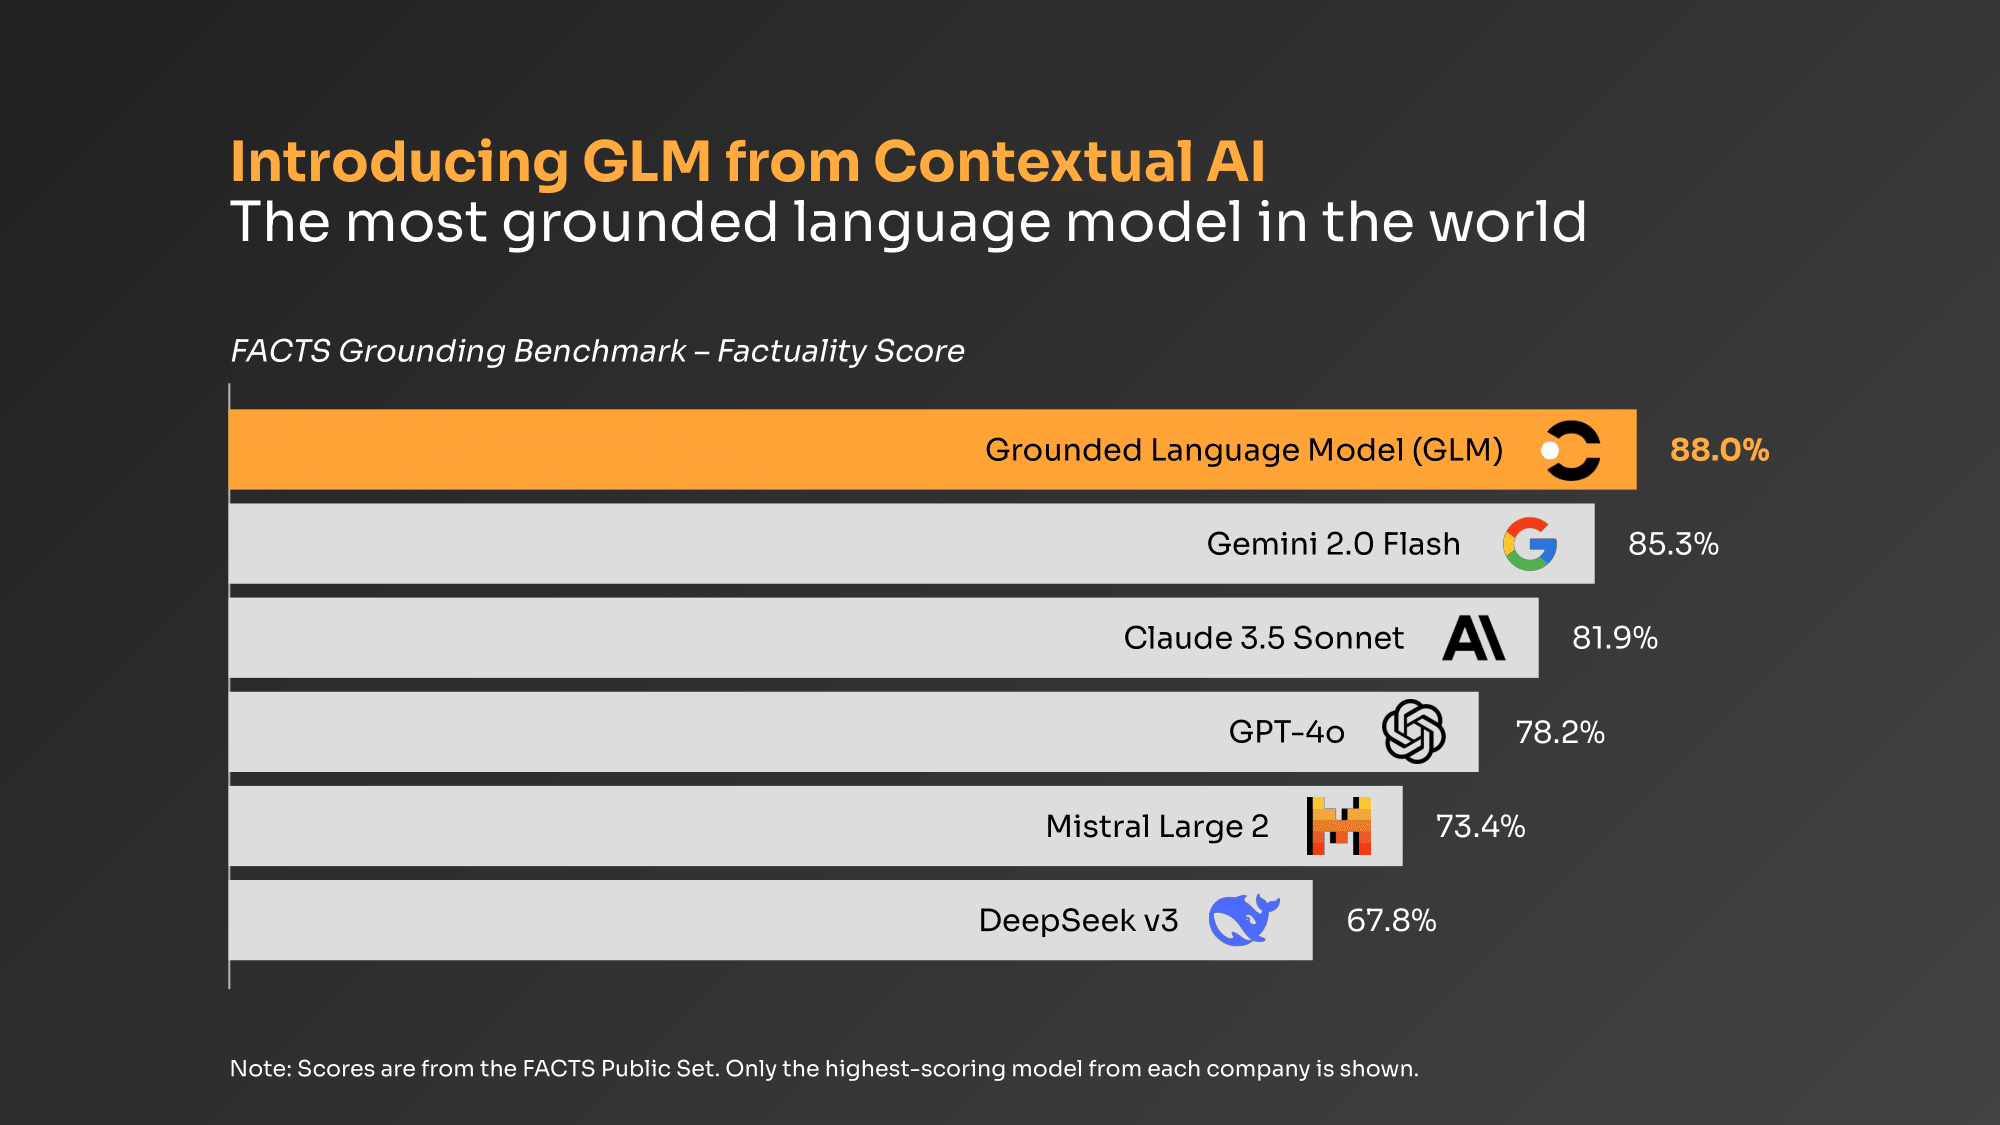

In [ ]:
# Example code:
generate_api_endpoint = f"{base_url}/generate"

In [ ]:
# Example conversation messages
messages = [
    {
        "role": "user",
        "content": "What are the most promising renewable energy technologies for addressing climate change in developing nations?"
    },
    {
        "role": "assistant",
        "content": "Based on current research, solar and wind power show significant potential for developing nations due to decreasing costs and scalability. Would you like to know more about specific implementation challenges and success stories?"
    },
    {
        "role": "user",
        "content": "Yes, please tell me about successful solar implementations in Africa and their economic impact, particularly focusing on rural electrification."
    }
]


# Detailed knowledge sources with varied information
knowledge = [
    """According to the International Renewable Energy Agency (IRENA) 2023 report:
    - Solar PV installations in Africa reached 10.4 GW in 2022
    - The cost of solar PV modules decreased by 80% between 2010 and 2022
    - Rural electrification projects have provided power to 17 million households""",

    """Case Study: Rural Electrification in Kenya (2020-2023)
    - 2.5 million households connected through mini-grid systems
    - Average household income increased by 35% after electrification
    - Local businesses reported 47% growth in revenue
    - Education outcomes improved with 3 additional study hours per day""",

    """Economic Analysis of Solar Projects in Sub-Saharan Africa:
    - Job creation: 25 jobs per MW of installed capacity
    - ROI average of 12-15% for mini-grid projects
    - Reduced energy costs by 60% compared to diesel generators
    - Carbon emissions reduction: 2.3 million tonnes CO2 equivalent""",

    """Technical Specifications and Best Practices:
    - Optimal solar panel efficiency in African climate conditions: 15-22%
    - Battery storage requirements: 4-8 kWh per household
    - Maintenance costs: $0.02-0.04 per kWh
    - Expected system lifetime: 20-25 years""",

    """Social Impact Assessment:
    - Women-led businesses increased by 45% in electrified areas
    - Healthcare facilities reported 72% improvement in service delivery
    - Mobile money usage increased by 60%
    - Agricultural productivity improved by 28% with electric irrigation"""
]

In [ ]:
import requests

headers = {
    "accept": "application/json",
    "content-type": "application/json",
    "authorization": f"Bearer {userdata.get('CONTEXTUAL_API_KEY')}"
}

In [ ]:
payload = {
    "model": "v1",
    "messages": messages,
    "knowledge": knowledge,
    "avoid_commentary": False,
    "max_new_tokens": 1024,
    "temperature": 0,
    "top_p": 0.9
}

generate_response = requests.post(generate_api_endpoint, json=payload, headers=headers)

print(generate_response.json()['response'])

Let me share the current state of solar energy implementation in Africa, focusing on rural electrification and its economic impact:

Africa has seen significant solar PV adoption, with total installations reaching 10.4 GW as of 2022, supported by an 80% decrease in solar PV module costs between 2010 and 2022.

The impact on rural electrification has been particularly noteworthy:

Rural electrification initiatives have already connected 17 million households to electricity. A specific case study in Kenya (2020-2023) demonstrates impressive results:
- 2.5 million households were connected through mini-grid systems
- Average household income increased by 35% after electrification
- Local businesses saw 47% growth in revenue
- Education improved with 3 additional study hours per day

The economic benefits extend beyond household income:

The solar industry has created substantial economic opportunities:
- Each megawatt of installed capacity generates 25 jobs
- Mini-grid projects typically 

## 4. [LMUnit](https://github.com/ContextualAI/examples/blob/main/03-standalone-api/01-lmunit/lmunit.ipynb)

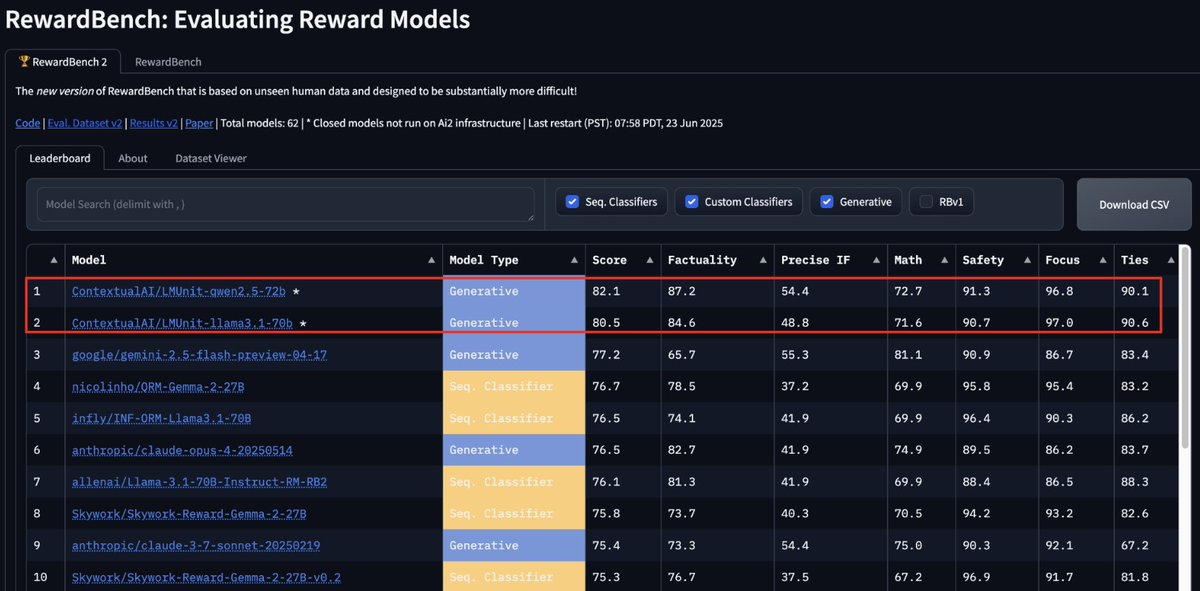

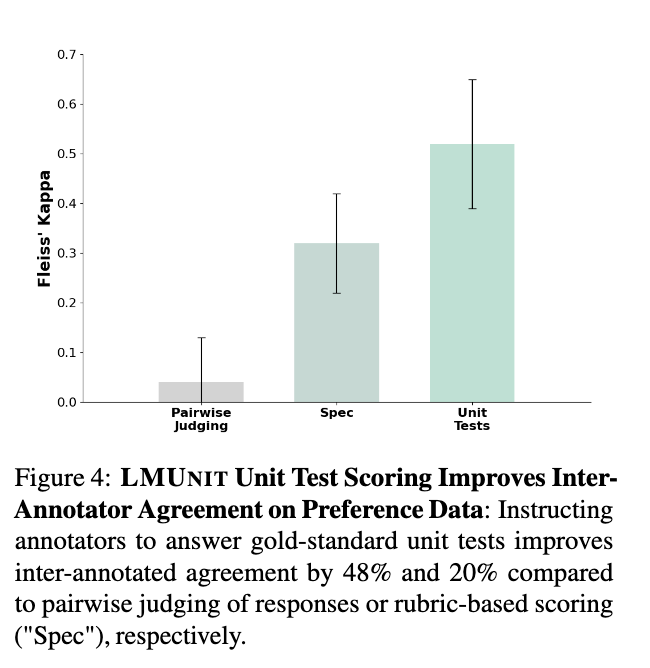

[Leaderboard](https://huggingface.co/spaces/allenai/reward-bench)

[RewardBench2 code submission](https://github.com/ContextualAI/examples/tree/main/09-lmunit-rewardbench)

[Paper](arxiv.org/abs/2412.13091)

In [ ]:
# Example code in the examples below

# Now let's do a Platform/Components deep dive!

[Workshop slide deck](https://contextual.ai/workshop)

## Step 5: Evaluate your Agent



We’ll now run a quick evaluation using our **`lmunit`** endpoint. For more details, check out the [blog post](https://contextual.ai/blog/lmunit/) and the [full notebook](https://github.com/ContextualAI/examples/blob/main/03-standalone-api/01-lmunit/lmunit.ipynb) focused on **`lmunit`**—a language model optimized for evaluating natural language unit tests.

**Natural Language Unit Testing** enables you to:

- Break down evaluation into specific, testable criteria  
- Get granular feedback on various quality aspects  
- Drive systematic improvements in LLM outputs  
- Support domain-specific quality standards  

Let’s begin with an evaluation dataset we’ve prepared in advance.

In [ ]:
# # FYI Here is how we created the eval dataset: (commented out for running live)

# # RAG Evaluation Questions
# questions = [
#    "What was NVIDIA's Data Center revenue in Q4 FY25?",
#    "What is the correlation coefficient between Neptune's distance from the Sun and US burglary rates?",
#    "How did NVIDIA's total revenue change from Q1 FY22 to Q4 FY25?",
#    "What are the four main reasons why spurious correlations work, according to the Tyler Vigen documents?",
#    "Why should we be skeptical of the correlation between Unilever's revenue and Google searches for 'lost my wallet'?",
#    "When did NVIDIA’s data center revenue overtake gaming revenue?"
# ]

# # Create DataFrame from questions
# eval = pd.DataFrame({'prompt': questions})
# eval['response'] = ''

# # Query the agent for each question
# for index, row in eval.iterrows():
#    try:
#        query_result = client.agents.query.create(
#            agent_id=agent_id,
#            messages=[{
#                "content": row['prompt'],
#                "role": "user"
#            }]
#        )
#        eval.at[index, 'response'] = query_result.message.content
#    except Exception as e:
#        print(f"Error processing row {index}: {e}")
#        eval.at[index, 'response'] = f"Error: {e}"

# print(eval[['prompt', 'response']])
# # prompt: save eval as csv

# eval.to_csv('eval_input.csv', index=False)

                                              prompt  \
0  What was NVIDIA's Data Center revenue in Q4 FY25?   
1  What is the correlation coefficient between Ne...   
2  How did NVIDIA's total revenue change from Q1 ...   
3  What are the four main reasons why spurious co...   
4  Why should we be skeptical of the correlation ...   
5  When did NVIDIA’s data center revenue overtake...   

                                            response  
0  NVIDIA's Data Center revenue for Q4 FY25 was $...  
1  The correlation coefficient (r) between Neptun...  
2  I can provide NVIDIA's total revenue for Q1 FY...  
3  Based on the provided documentation, here are ...  
4  There are several compelling reasons to be ske...  
5  Based on the provided data, I can identify whe...  


In [ ]:
# polar plots
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, Tuple

#clustering analysis
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [ ]:
# Check if the CSV file already exists
if not os.path.exists('data/eval_input.csv'):
    print(f"Fetching data/eval_input.csv")

    # Download the CSV file from GitHub
    response = requests.get("https://raw.githubusercontent.com/ContextualAI/examples/refs/heads/main/08-ai-workshop/data/eval_input.csv")

    # Save the downloaded content
    with open('data/eval_input.csv', 'wb') as f:
        f.write(response.content)

eval = pd.read_csv('data/eval_input.csv')
eval.head()

Fetching data/eval_input.csv


prompt  \
0  What was NVIDIA's Data Center revenue in Q4 FY25?   
1  What is the correlation coefficient between Ne...   
2  How did NVIDIA's total revenue change from Q1 ...   
3  What are the four main reasons why spurious co...   
4  Why should we be skeptical of the correlation ...   

                                            response  
0  NVIDIA's Data Center revenue for Q4 FY25 was $...  
1  The correlation coefficient (r) between Neptun...  
2  I can provide NVIDIA's total revenue for Q1 FY...  
3  Based on the provided documentation, here are ...  
4  There are several compelling reasons to be ske...

For this example, we will use global unit tests that we will run across all our responses. The following were six critical dimensions for quantitative reasoning we chose as unit tests:

1. **Accuracy**  
   - *Question:* "Does the response accurately extract specific numerical data from the documents?"  
   - *Why:* Ensures responses correctly identify and use quantitative information  

2. **Causation**  
   - *Question:* "Does the agent properly distinguish between correlation and causation?"  
   - *Why:* Tests whether analytical reasoning is sound and avoids logical fallacies  

3. **Synthesis**  
   - *Question:* "Are multi-document comparisons performed correctly with accurate calculations?"  
   - *Why:* Validates ability to synthesize information across sources  

4. **Limitations**  
   - *Question:* "Are potential limitations or uncertainties in the data clearly acknowledged?"  
   - *Why:* Ensures appropriate caveats and transparency  

5. **Evidence**  
   - *Question:* "Are quantitative claims properly supported with specific evidence from the source documents?"  
   - *Why:* Tests whether conclusions are properly grounded in source material  

6. **Relevance**  
   - *Question:* "Does the response avoid unnecessary information?"  
   - *Why:* Verifies responses stay focused and concise  


In [ ]:
unit_tests = [
      "Does the response accurately extract specific numerical data from the documents?",
      "Does the agent properly distinguish between correlation and causation?",
      "Are multi-document comparisons performed correctly with accurate calculations?",
      "Are potential limitations or uncertainties in the data clearly acknowledged?",
      "Are quantitative claims properly supported with specific evidence from the source documents?",
      "Does the response avoid unnecessary information?"
]

LMUnit is specifically trained for evaluating natural language unit tests and provides:

* Scores on a continuous 1-5 scale
* Consistent evaluation across different criteria
* Better performance than general-purpose LLMs like GPT-4
* Ability to add rubrics to evaluation
* Apply thresholds to get binary scores, e.g., if score is greater than 2.5 is 1 else 0

Let's start with a simple example to understand how LMUnit works:

In [ ]:
response = client.lmunit.create(
                    query="What was NVIDIA's Data Center revenue in Q4 FY25?",
                   response = """NVIDIA's Data Center revenue for Q4 FY25 was $35,580 million.\[1\]()

                                This represents a significant increase from the previous quarter (Q3 FY25) when Data Center revenue was $30,771 million.[1]()

                                The full quarterly trend for Data Center revenue in FY25 was:
                                - Q4 FY25: $35,580 million
                                - Q3 FY25: $30,771 million
                                - Q2 FY25: $26,272 million
                                - Q1 FY25: $22,563 million[1]()
                              """,
                    unit_test="Does the response avoid unnecessary information?"
                )
print(response)

LMUnitCreateResponse(score=2.359)


The response **did** include unnecessary information! Later we can tweak our prompt to better fit this requirement. Now let's test the full batch:

In [ ]:
def run_unit_tests_with_progress(
    df: pd.DataFrame,
    unit_tests: List[str],
    batch_size: int = 10
) -> List[Dict]:
    """
    Run unit tests with progress tracking and error handling.

    Args:
        df: DataFrame with prompt-response pairs
        unit_tests: List of unit test strings
        batch_size: Number of tests to run in parallel

    Returns:
        List of test results
    """
    results = []

    # Iterate over the DataFrame rows
    for idx in tqdm(range(0, len(df)), desc="Processing responses"):
        row = df.iloc[idx]
        row_results = []

        # Run each unit test on the current prompt-response pair
        for test in unit_tests:
            try:
                result = client.lmunit.create(
                    query=row['prompt'],
                    response=row['response'],
                    unit_test=test
                )

                # Collect the test result score and metadata if available
                row_results.append({
                    'test': test,
                    'score': result.score,
                    'metadata': result.metadata if hasattr(result, 'metadata') else None
                })

            except Exception as e:
                print(f"Error with prompt {idx}, test '{test}': {e}")
                row_results.append({
                    'test': test,
                    'score': None,
                    'error': str(e)
                })

        # Store results
        results.append({
            'prompt': row['prompt'],
            'response': row['response'],
            'test_results': row_results
        })

    return results

In [ ]:
from tqdm import tqdm
results = run_unit_tests_with_progress(eval, unit_tests)

Processing responses: 100%|██████████| 6/6 [01:25<00:00, 14.30s/it]


In [ ]:
for result in results[:2]:  # Slice to get the first two entries
    print(f"\nPrompt: {result['prompt']}")
    print(f"Response: {result['response']}")
    print("Test Results:")
    for test_result in result['test_results']:
        print(f"- {test_result['test']}: {test_result['score']}")


Prompt: What was NVIDIA's Data Center revenue in Q4 FY25?
Response: NVIDIA's Data Center revenue for Q4 FY25 was $35,580 million.[1]()[2]()

This represents the largest segment of NVIDIA's total revenue for the quarter, which was $39,331 million.[1]()[2]()
Test Results:
- Does the response accurately extract specific numerical data from the documents?: 3.459
- Does the agent properly distinguish between correlation and causation?: 1.574
- Are multi-document comparisons performed correctly with accurate calculations?: 2.494
- Are potential limitations or uncertainties in the data clearly acknowledged?: 1.297
- Are quantitative claims properly supported with specific evidence from the source documents?: 2.949
- Does the response avoid unnecessary information?: 2.386

Prompt: What is the correlation coefficient between Neptune's distance from the Sun and US burglary rates?
Response: The correlation coefficient (r) between Neptune's distance from the Sun and US burglary rates from 1985-20

In [ ]:
pd.DataFrame([(r['prompt'], r['response'], t['test'], t['score']) for r in results for t in r['test_results']], columns=['prompt', 'response', 'test', 'score']).to_csv(f"unit_test_results.csv", index=False)
df = pd.read_csv("unit_test_results.csv")

In [ ]:
def map_test_to_category(test_question: str) -> str:
    """Map the full test question to its category."""
    category_mapping = {
        'Does the response accurately extract specific numerical data': 'ACCURACY',
        'Does the agent properly distinguish between correlation and causation': 'CAUSATION',
        'Are multi-document comparisons performed correctly': 'SYNTHESIS',
        'Are potential limitations or uncertainties in the data': 'LIMITATIONS',
        'Are quantitative claims properly supported with specific evidence': 'EVIDENCE',
        'Does the response avoid unnecessary information': 'RELEVANCE'
    }

    for key, value in category_mapping.items():
        if key.lower() in test_question.lower():
            return value
    return None

def create_unit_test_plots(results: List[Dict],
                          test_indices: Optional[Union[int, List[int]]] = None,
                          figsize: tuple = (10, 10)):
    """
    Create polar plot(s) for unit test results. Can plot either a single test,
    specific multiple tests, or all tests in a row.

    Args:
        results: List of dictionaries containing test results
        test_indices: Optional; Either:
            - None (plots all results)
            - int (plots single result)
            - List[int] (plots multiple specific results)
        figsize: Tuple specifying the figure size (width, height)
    """
    # Handle different input cases for test_indices
    if test_indices is None:
        indices_to_plot = list(range(len(results)))
    elif isinstance(test_indices, int):
        if test_indices >= len(results):
            raise IndexError(f"test_index {test_indices} is out of range. Only {len(results)} results available.")
        indices_to_plot = [test_indices]
    else:
        if not test_indices:
            raise ValueError("test_indices list cannot be empty")
        if max(test_indices) >= len(results):
            raise IndexError(f"test_index {max(test_indices)} is out of range. Only {len(results)} results available.")
        indices_to_plot = test_indices

    # Categories in desired order
    categories = ['ACCURACY', 'CAUSATION', 'SYNTHESIS',
                'LIMITATIONS', 'EVIDENCE', 'RELEVANCE']

    # Set up the angles for the polar plot
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # Close the plot

    # Calculate figure size based on number of plots
    num_plots = len(indices_to_plot)
    fig_width = figsize[0] * num_plots
    fig = plt.figure(figsize=(fig_width, figsize[1]))

    # Create a subplot for each result
    for plot_idx, result_idx in enumerate(indices_to_plot):
        result = results[result_idx]

        # Create subplot
        ax = plt.subplot(1, num_plots, plot_idx + 1, projection='polar')

        # Get scores for this result
        scores = []
        for category in categories:
            score = None
            for test_result in result['test_results']:
                mapped_category = map_test_to_category(test_result['test'])
                if mapped_category == category:
                    score = test_result['score']
                    break
            scores.append(score if score is not None else 0)

        # Close the scores array
        scores = np.concatenate((scores, [scores[0]]))

        # Plot the scores
        ax.plot(angles, scores, 'o-', linewidth=2)
        ax.fill(angles, scores, alpha=0.25)

        # Set the labels
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)

        # Set the scale
        ax.set_ylim(0, 5)

        # Add grid
        ax.grid(True)

        # Add score values as annotations
        for angle, score, category in zip(angles[:-1], scores[:-1], categories):
            ax.text(angle, score + 0.2, f'{score:.2f}',
                    ha='center', va='bottom')

        # Add title for each subplot
        prompt = result['prompt']
        ax.set_title(f"Test {result_idx}\n{prompt}", pad=20)

    plt.tight_layout()
    return fig

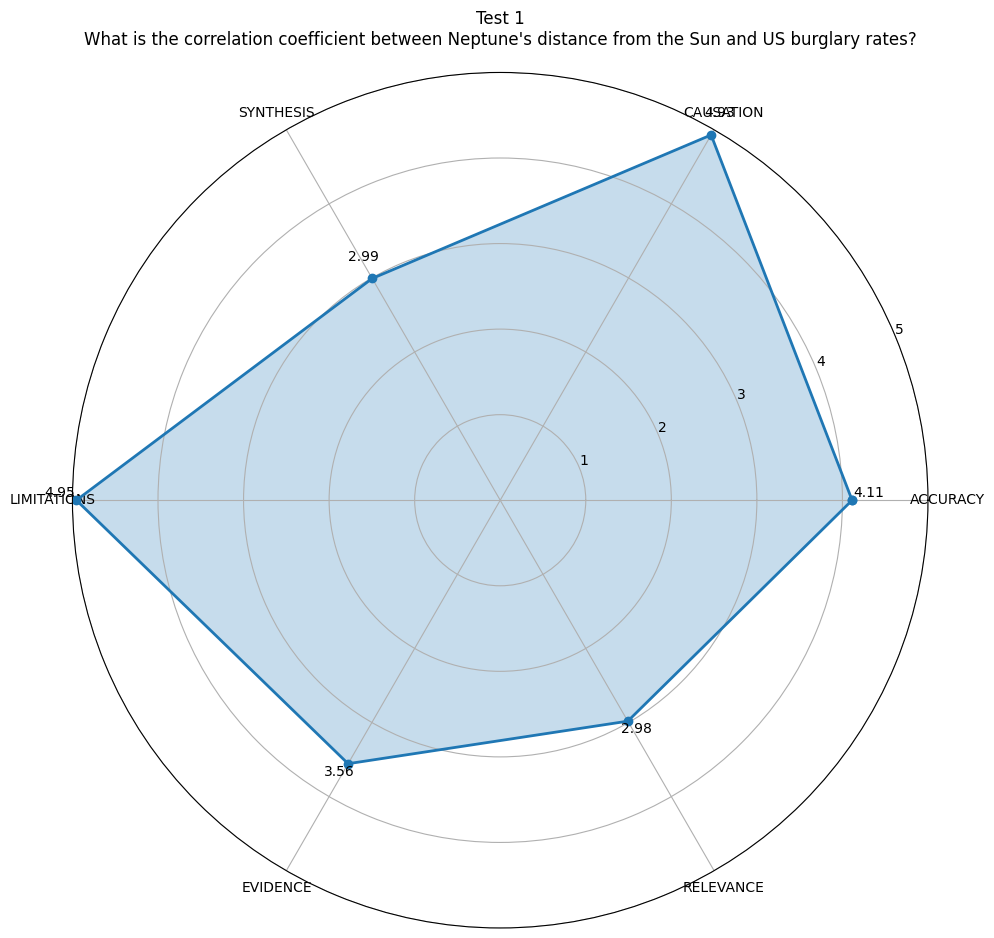

In [ ]:
# Plot the second test result
fig = create_unit_test_plots(results, test_indices=1)

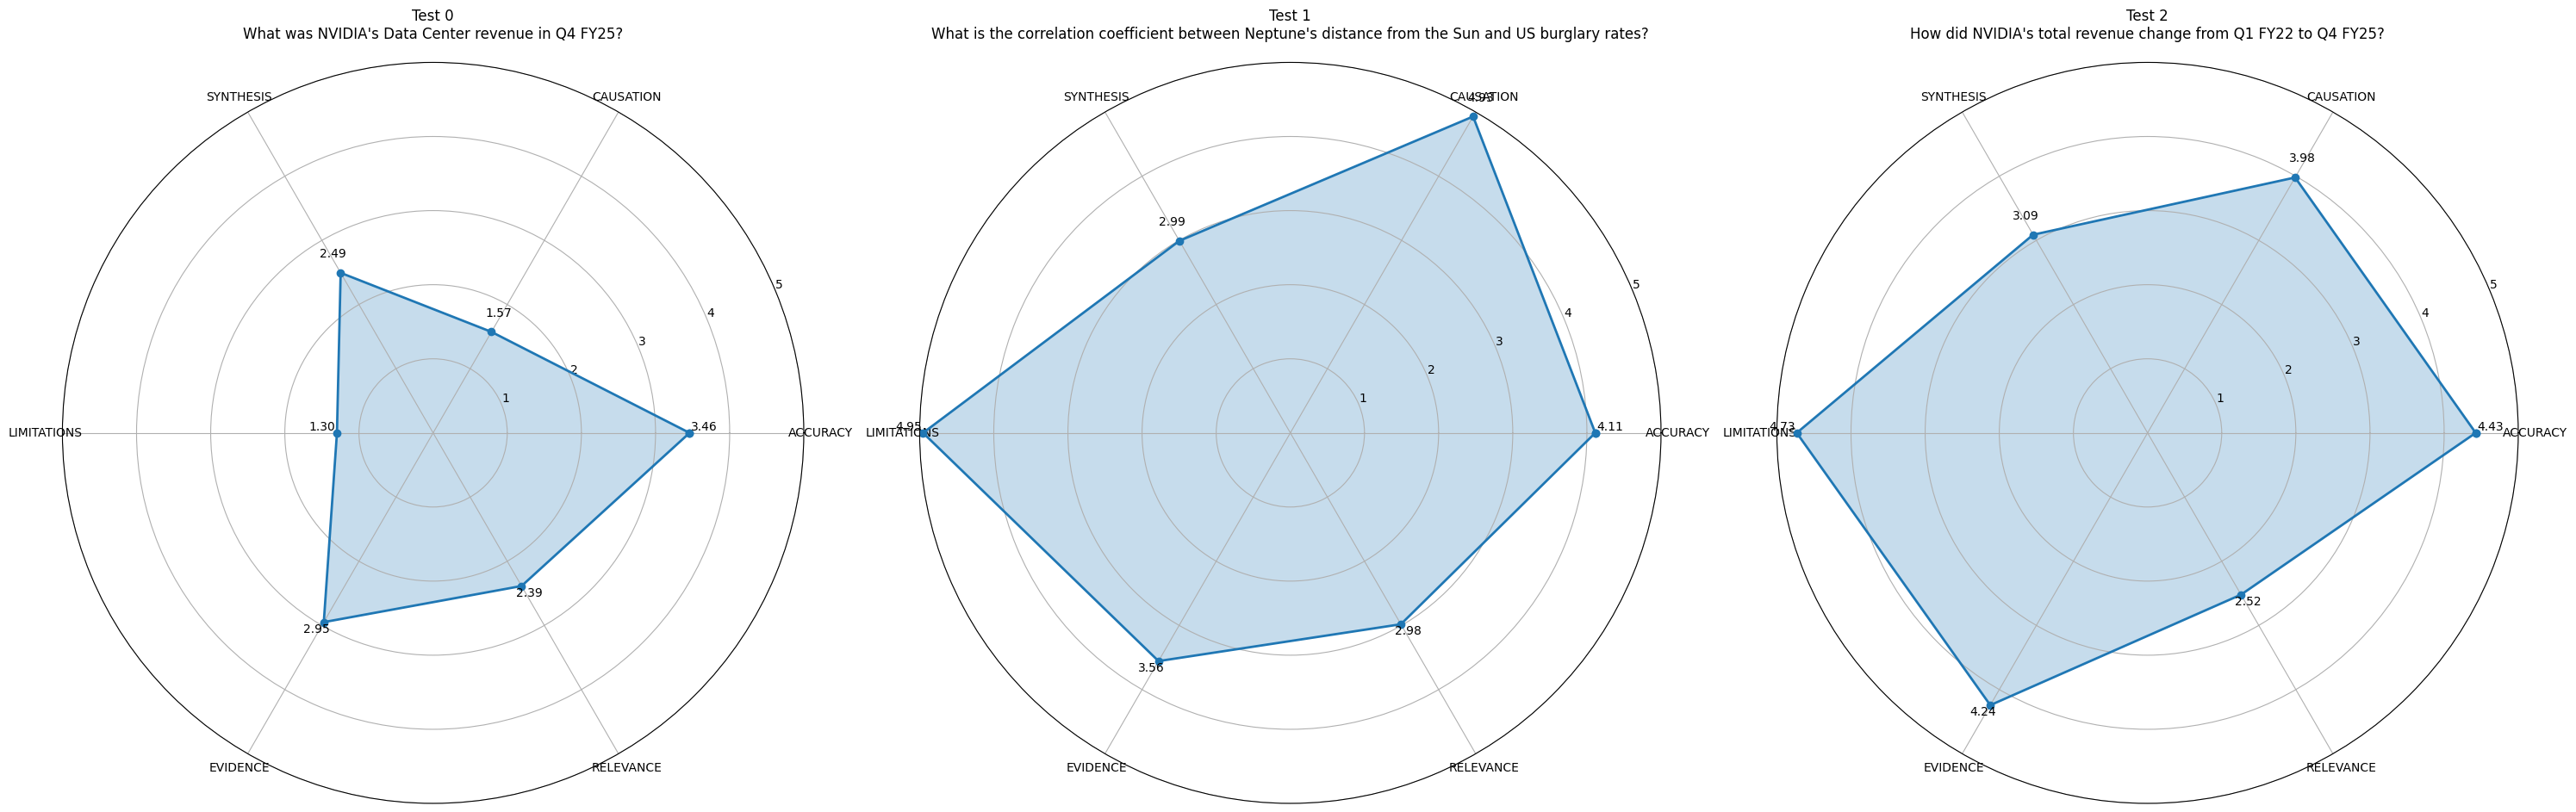

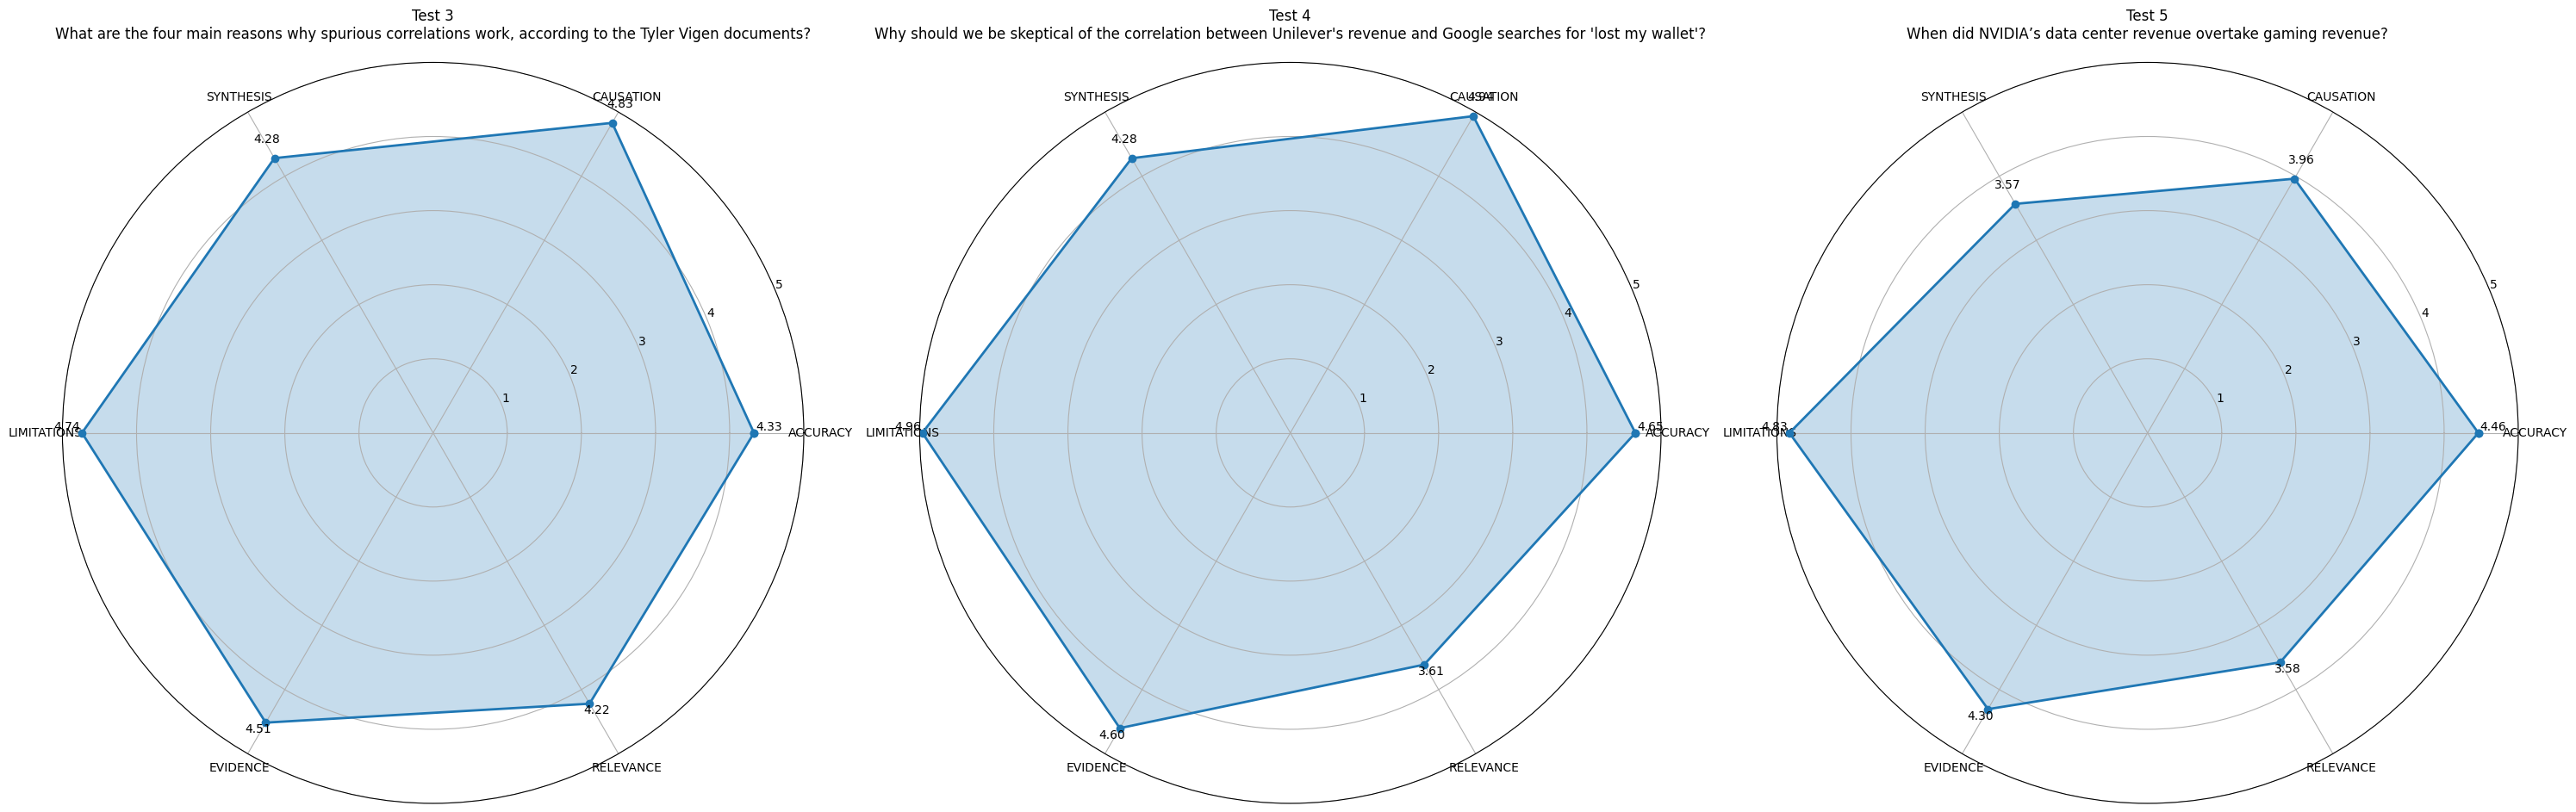

In [ ]:
fig = create_unit_test_plots(results, test_indices=[0, 1, 2])
fig = create_unit_test_plots(results, test_indices=[3, 4, 5])

# Homework #1: Improving the agent based on the unit test results

## Step 6: Improving your Agent

Contexual AI give you multiple methods for improving your overall agent performance.

Let's go through a specific option with code to update the agent in your Platform:

### 6.1 Revising the system prompt


After initial testing, you may want to revise the system prompt. Here I have the default prompt for you to tweak to change the unit test performance of the RAG system.  

In [ ]:
system_prompt2 = '''
You are a helpful AI assistant created by Contextual AI to answer questions about relevant documentation provided to you. Your responses should be precise, accurate, and sourced exclusively from the provided information. Please follow these guidelines:
* Only use information from the provided documentation. Avoid opinions, speculation, or assumptions.
* Use the exact terminology and descriptions found in the provided content.
* Keep answers concise and relevant to the user's question.
* Use acronyms and abbreviations exactly as they appear in the documentation or query.
* Apply markdown if your response includes lists, tables, or code.
* Directly answer the question, then STOP. Avoid additional explanations unless specifically relevant.
* If the information is irrelevant, simply respond that you don't have relevant documentation and do not provide additional comments or suggestions. Ignore anything that cannot be used to directly answer this query.
* If you are asked about what information you have access to or who you are, respond with "I am an AI assistant created by Contextual AI. I don't have relevant documentation about that topic, but feel free to ask me something else!"
* If the question is a pleasantry like "hello" or is not related to the knowledge chunks provided to you, respond with a polite "Hello, I am an AI assistant created by Contextual AI. I don't have relevant documentation about that topic, but feel free to ask me something else!"
'''


Let's now update the agent. And verify that changes by checking the agent metadata.

In [ ]:
client.agents.update(agent_id=agent_id, system_prompt=system_prompt2)

agent_config = client.agents.metadata(agent_id=agent_id)
print (agent_config.system_prompt)

Now that you have updated the agent, go try running another evaluation job. You will see the performance has improved.

# Homework #2: Try the above with your own data and Agent configuration!

# Extra Credit: Connecting your agent to an MCP Client of your choice

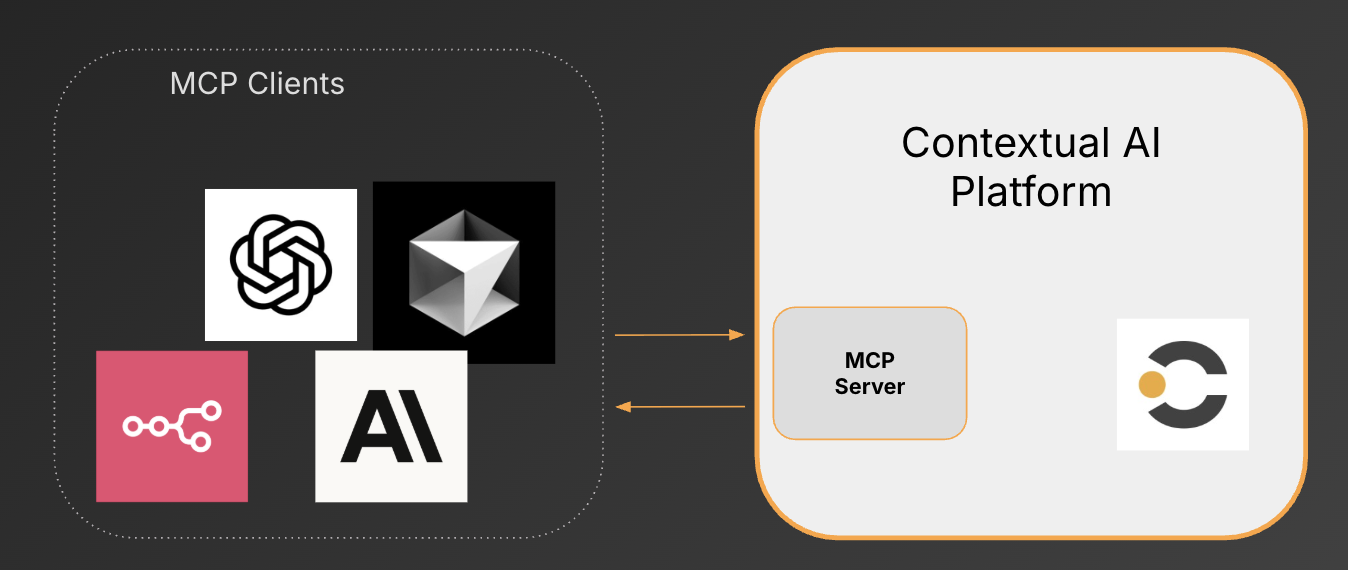

### References:
[Documentation for Local + Remote MCP Servers](https://docs.contextual.ai/user-guides/mcp-server)

[GitHub](https://github.com/ContextualAI/contextual-mcp-server)

[YouTube how to for the local MCP server](https://youtu.be/bwGUl0dThHE)


# Extra credit # 2
[Please fill out our Survey to share your feedback!](https://forms.gle/4z1wGZGGxX1AHUML9)

## Next Steps

In this Notebook, we've created and evaluated a RAG agent, and pointed you to notebooks for the component API endpoints (lmunit, parse, rerank, and generate). You can learn more at [docs.contextual.ai](https://docs.contextual.ai/). Finally, reach out to info@contextual.ai if you have further questions or issues.